## practicalMixGaussA

October 2017: This lab has been converted to Python by Stratos Skordos. Any errors are my fault.  
October 2018: This lab has been checked by Mohamed Sayed. Any errors are now my fault.

Tested against Python 3.6.6. Required Python modules:
* numpy
* scipy
* matplotlib
* pillow


This lab explores fitting simple parametric models to visual data.
The goal of this part of the lab (part A) is to fit one Gaussian model to the
data for skin and another Gaussian to non-skin pixels, and use this to
find the posterior probability that each pixel in an image is skin.
The aim of part B is to fit a mixture of
Gaussians model to one dimensional data. The aim of part C is to fit a
mixture of Gaussians model to the RGB data.
The aim of Part D is to apply what we've learned to real data.

You should use this template for your code and fill in the missing
sections marked "TO DO".




-----------------------------------
PLEASE NOTE: When implementing equations, you should only be using
"simple" numpy commands, such as np.mean(). When it comes to functions like cov(), you should
implement them yourself to show that you know what the functions are doing. 

You can check your cov() implementation against numpy's, **but
beware, sometimes there are subtle differences
between vanilla equations and what the numpy implememntation uses.**

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio

from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

%matplotlib inline


Load in a test image and the corresponding ground truth segmentation mask. Your goal for this part of the lab is to segment this 
image and acheive a segmentation mask that's close to the ground truth mask.

In [2]:
#loading the image
im = plt.imread('bob_small.jpeg')
#loading the segmentation mask
gt = spio.loadmat('bob_GroundTruth_small.mat', squeeze_me=True)['gt']
print("The shape of im is:", im.shape)
print("The shape of gt is:", gt.shape)

The shape of im is: (100, 100, 3)
The shape of gt is: (150, 150)


[]

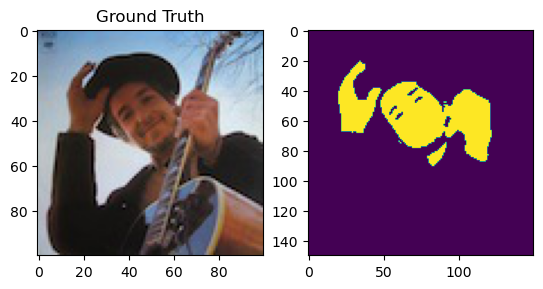

In [3]:
# display the test image and the ground truth mask
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im)
ax1.set_title('Image')
ax2.imshow(gt)
ax1.set_title('Ground Truth')
ax1.plot()

On the left we have the actual image taken by the camera, on the right we have a hand-made mask of the pixels in the image that contain human skin.
\
\
The idea behind this is for us to construct two different vectors, one containing pixels of skin and the other pixels of no skin.
\
\
Once we have those vectors, we can train our model to recognise RGB values for skin and non skin pixels.

Load in training data. The file contains two variables. Both are sized at 3 x 10000 (3 for RGB dimensions 
and 10000 for the number of data pixels). Each column contains RGB information for one pixel. 

In [4]:
# load the file
trainingData = spio.loadmat('RGBSkinNonSkin.mat', squeeze_me=True) #Q what is a .mat file?

#extract the non-skin matrix
RGBNonSkin = np.float32(trainingData['RGBNonSkin'])
#extract the skin matrix
RGBSkin = np.float32(trainingData['RGBSkin'])

**TODO HERE**:

This function fits a single Gaussian distribution to your data. Fill in the TODO(s) now before moving on.
\
\
### Explanation of code:
For calculating the mean of each feature, I interpret the data to be a $N\times D$ matrix: N = number of data-points, D = number of features
\
\
For calculating the covariance matrix, I interpret our data to be a vector (length D) of vectors (length N each): $data = \vec{x}$ where $\vec{x} = (\textbf{x}_1, ..., \textbf{x}_D) $ and each $\textbf{x}_d = (x_1, ..., x_N)$
\
\
I then construct our covariance matrix following: $\left(\begin{smallmatrix} cov(\textbf{x}_1, \textbf{x}_1) & \cdots & cov(\textbf{x}_1, \textbf{x}_D)\\ \vdots & \ddots & \vdots \\ cov(\textbf{x}_D, \textbf{x}_1) & \cdots & cov(\textbf{x}_D, \textbf{x}_D)\\ \end{smallmatrix}\right)$.
\
\
Where $cov(\textbf{x}_{d1}, \textbf{x}_{d2}) = \frac{\sum_{n=1}^N \left((\textbf{x}_{d1} - \overline{\textbf{x}}_{d1}) * (\textbf{x}_{d2} - \overline{\textbf{x}}_{d2})\right)}{N-1}$. Where $*$ means element wise multiplication and subtraction of mean is also to each vector's element. Then we sum all of the N entries of the resulting vector and divide by N-1 (definition of covariance).

In [5]:
def fitGaussianModel(data):    
    """
    Returns the mean and covariance for a set of multidimensaional data.
    It is assumed that each column of the 2D array, data, contains a single data point.
    The mean vector should be a dx1 vector with the mean value of the data. For this lab, the output is a
    3 by 1 vector containing the RGB mean of the input pixels. The covariance should be a dxd covariance
    matrix. See the note at the top, which explains that using mean() is ok,
    but please compute the covariance yourself.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    
    Returns: 
    meanData -- d by 1 vector containing the mean value of the input data.
    covData -- d by d matrix containing the covariance of the input data.
    """
    #Please read above to understand what I did
    data = np.transpose(data) #I understand data to be N by D, so transpose it to make it easier for myself
    N,D = data.shape

    features_mean = np.mean(data, axis = 0) #Acquire mean of features using np.mean 

    covData = []
    for d_1 in range(D):
        d_row = []
        first_term = (data[:,d_1] - np.mean(data[:,d_1])) #Acquire x_d1 - mean(x_d1)
        for d_2 in range(D):
            second_term = (data[:,d_2] - np.mean(data[:,d_2])) #Acquire x_d2 - mean(x_d2)
            d_row.append(np.sum(first_term * second_term)/(len(first_term*second_term)-1)) #Calculate covariance for both terms and append it

        covData.append(d_row) #Append the row to the covariance matrix

    # Sanity check
    covData = np.array(covData)
    print("This is my covariance:\n" + str(covData))
    print("This is the numpy covariance:\n"+ str(np.cov(np.transpose(data))))

    return features_mean,covData 

Fit Gaussian models to the skin and non-skin data - make sure you've already filled in the TODO(s) in the above function.

In [6]:
#fit Gaussian model for non-skin data
meanSkin, covSkin = fitGaussianModel(RGBSkin)

#fit Gaussian model for non-skin data
meanNonSkin, covNonSkin = fitGaussianModel(RGBNonSkin)

This is my covariance:
[[2974.50105011 2582.86328633 2340.0770077 ]
 [2582.86328633 2741.91659166 2744.75967597]
 [2340.0770077  2744.75967597 3106.68046805]]
This is the numpy covariance:
[[2974.50084012 2582.86325179 2340.07713459]
 [2582.86325179 2741.91666446 2744.75969509]
 [2340.07713459 2744.75969509 3106.68057142]]
This is my covariance:
[[5104.54805481 4509.43094309 4362.1730173 ]
 [4509.43094309 4966.92229223 4917.89138914]
 [4362.1730173  4917.89138914 5746.4110411 ]]
This is the numpy covariance:
[[5104.54790275 4509.43066555 4362.17310487]
 [4509.43066555 4966.92194643 4917.8912164 ]
 [4362.17310487 4917.8912164  5746.41076424]]


**TODO HERE**:

This function evaluates a Gaussian likelihood on some data. Fill in the TODO(s) now before moving on.

In [7]:
#the goal of this routine is to evaluate a Gaussian likelihood
def calcGaussianProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    #Once again I transpose data to work with it better:
    data = np.transpose(data)
    N,D = data.shape
    
    like = []
    for n in range(N):
        n_row = data[n,:]
        like.append((2*np.pi**(-0.5*len(n_row)))
                    * ((np.linalg.det(gaussCov))**(-0.5)) 
                    * np.exp(-0.5*np.matmul(np.matmul(np.transpose(n_row - gaussMean),np.linalg.inv(gaussCov)), (n_row - gaussMean))))
    
    like = np.array(like)
    
    return like

**TODO HERE**:

It's time to use our models for inference on a test image. We will first define some priors on whether or not a pixel is human skin or not. We've defined these arbitrarily here, but other more informed priors can be inforced. 

We aim to calculate a posterior probability for whether or not a pixel is skin or not. Our liklihoods are defined by the gaussian models "trained" earlier.  

For debugging's sake, we loop over every pixel and calculate its posterior indivisually. Feel free to vectorize this entirely after you're done with the rest of the sections.

In [14]:
# let's define priors for whether the pixel is skin or non skin
priorSkin = 0.3
priorNonSkin = 0.7

# now run through the pixels in the image and classify them as being skin or
# non skin - we will fill in the posterior
imY, imX, imZ = im.shape
posteriorSkin = np.zeros([imY,imX])

for cY in range(imY): 
    print('Processing Row ',cY,'\n')
    for cX in range(imX):
        #extract this pixel's data
        thisPixelData = np.double(im[cY,cX,:])
        thisPixelData = thisPixelData[:, np.newaxis]
        
        #make sure you've filled in calcGaussianProb above.
        
        #calculate likelihood of this data given skin model
        likeSkin = calcGaussianProb(thisPixelData,meanSkin,covSkin)
        #calculate likelihood of this data given non skin model
        likeNonSkin = calcGaussianProb(thisPixelData,meanNonSkin,covNonSkin)
        posteriorSkin[cY,cX] = likeSkin * priorSkin

Processing Row  0 

Processing Row  1 

Processing Row  2 

Processing Row  3 

Processing Row  4 

Processing Row  5 

Processing Row  6 

Processing Row  7 

Processing Row  8 

Processing Row  9 

Processing Row  10 

Processing Row  11 

Processing Row  12 

Processing Row  13 

Processing Row  14 

Processing Row  15 

Processing Row  16 

Processing Row  17 

Processing Row  18 

Processing Row  19 

Processing Row  20 

Processing Row  21 

Processing Row  22 

Processing Row  23 

Processing Row  24 

Processing Row  25 

Processing Row  26 

Processing Row  27 

Processing Row  28 

Processing Row  29 

Processing Row  30 

Processing Row  31 

Processing Row  32 

Processing Row  33 

Processing Row  34 

Processing Row  35 

Processing Row  36 

Processing Row  37 

Processing Row  38 

Processing Row  39 

Processing Row  40 

Processing Row  41 

Processing Row  42 

Processing Row  43 

Processing Row  44 

Processing Row  45 

Processing Row  46 

Processing Row  47 

Pr

# Display the results!

Text(0.5, 1.0, 'Result')

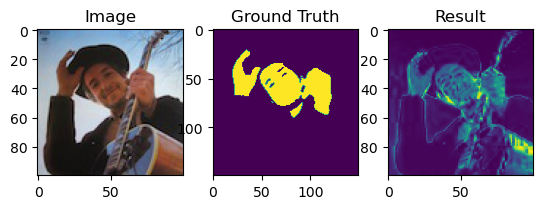

In [15]:
# set up plots.
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
#show the image
ax1.imshow(im)
ax1.set_title('Image')
#show the ground truth mask
ax2.imshow(gt)
ax2.set_title('Ground Truth')
#show our prediction!
ax3.imshow(posteriorSkin)
ax3.set_title('Result')

The image on the right is the predicted posterior our model produces after training it with the image on the left. We have recognised the skin pixels and the non skin pixels thanks to the ground truth mask, and have used a gaussian as a model to recognise skin vs non skin pixels.
\
\
The brighter the pixel, the higher the chance that pixel is skin, according to our model. We can see this model does not produce clean resultsm as it recognises as skin the majority of the guitar.